<a target="_blank" href="https://colab.research.google.com/github/astrostatistics-in-crete/2024_summer_school/blob/main/11_SBI/SBI_full.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Simulation-Based Inference**

In [ ]:
# ! pip install --upgrade emcee pytorch-lightning nflows getdist --quiet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner
from scipy.stats import norm
from getdist import plots, MCSamples
from scipy.integrate import quad

In [2]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [3]:
import multiprocessing
from multiprocessing import Pool

In [4]:
%matplotlib inline

In [5]:
torch.__version__

'2.3.0'

# 1. Introduction

## 1.1. Revisiting Bayesian Inference

The goal of Bayesian inference is given a model and some observed data $x$, to infer the distribution of the model parameters $\theta$ that are consistent with the data, i.e. the posterior distribution $p(\theta|x)$. This is achieved using Bayes' theorem: 
$$ p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}$$

In astronomy, the observed data $x$ and the respective parameters $\theta$ can be e.g.:

| <center> x </center> | <center> θ </center> |
| --- | --- |
| observed X-ray photon count of a galaxy cluster | the mass of the cluster |
|  gravitational wave signal from a collapsing black hole binary | the mass ratio and ellipticity of the binary |
|  2D sky projection of galaxy weak lensing measurements | the cosmological parameters governing dark matter and dark energy |

<p float="center">
<center>
  <img src="assets/likelihood_prior_posterior.png" width="500" />
  <img src="assets/prior_lh_post.png" width="300" /> 
 </center> 
</p>

<small> 

<i>Figure 1 (Left):</i> Example of Bayesian inference with a prior distribution, a posterior distribution, and a likelihood function. Taken from https://doi.org/10.3389/fncom.2019.00002 .

<i>Figure 2 (Right):</i> The prior, likelihood and posterior distributions for an arbitrary 1D inference problem. Given an observed data point $x_0$ (in black), we want to infer the posterior constraints on the model parameter $\theta$. Taken from https://doi.org/10.48550/arXiv.2402.05137 .

</small>


### 1.1.1. Let's first remind ourselves of what the Likelihood function is:
The likelihood function quantifies how likely the <span style="color:darkorange">*observed data*</span> is, given a set of <span style="color:darkorange">*model parameters*</span>, that describe our theory. Essentially, the likelihood is what we know about how the data was generated, and it describes this probabilistic process the data went through and how it depends on the model parameters.

Given some data/observations $x$, generated through some stochastic process, we can sometimes <span style="color:darkorange">*construct*</span> a likelihood function that describes the probability of observing the data given some parameters $\theta$. 

Normally, we derive the analytical form of the likelihood function from the <span style="color:darkorange">theory</span>, combined with some <span style="color:darkorange">assumptions about the noise</span> in the data or <span style="color:darkorange">unknown physics</span> (e.g. assume Gaussian distribution for continuous data, Poisson distribution for count data).

### 1.1.2. The limits of traditional inference:
What we have described so far is the traditional Bayesian inference, where we write down an *analytical* form of the likelihood. Afterwards, we can sometimes analytically compute the posterior distribution (if the evidence term is tractable)
or use sampling methods (e.g. MCMC) to sample from it.

However, we often encounter complex systems where the underlying processes are not fully understood or are too complicated to model analytically &rarr; <span style="color:darkorange">for a general inference problem, we may not know which likelihood function to choose or whether this choice is valid.</span>

**So, what happens when we cannot write down an analytical form of the likelihood?**

<details>
<summary><span style="color:red"> <b>[Spoiler]</b> (click here to expand)</span></summary>
We can resort to...
<img src=assets/sponge_bob.jpg width=400>
</details>


## 1.2. Simulators

Simulators are <span style="color:darkorange">computer programs that generate synthetic data from a model</span>. They take as **input** a set of parameters $\theta$, sample a series of internal states or **latent variables**, $z_i \sim p(z_i | z_{<i}, \theta)$, and then **generate** a data vector $x \sim p(x | z, \theta)$.

In astronomy, some examples of simulators are:
- **N-body simulations**: simulate the evolution of a system of particles under the influence of gravity.
- **Galaxy formation simulations**: simulate the formation and evolution of galaxies.
- **Stellar population synthesis**: simulate the spectral energy distribution of a stellar population.

The **latent variables** $z$ can be:
- **physical quantities** that are not directly observable (e.g. position of a particle in an N-body simulation).
- **non-physical quantities** that are internal to the simulator, and do not have a direct physical interpretation (e.g. some internal state).

<center><img src="assets/lfi_sim_dark.png" width="800">

<small> <i>Figure 3:</i> The simulator takes as input the model parameters $\theta$ and generates synthetic data $x$. We can view the simulator as a black box function that can be used to generate data for any set of parameters. </small></center>
</center>




The question is: 

***How can we use simulations to perform inference?***

## 1.3. Simulation-based inference: The basic idea
Instead of trying to analytically evaluate the likelihood, we can build a **forward model** of the data &rarr; the stochastic **simulator** becomes the physical **model**.

The <span style="color:darkorange">outputs of the simulator</span> are this way <span style="color:darkorange">samples of the observational data</span> that we would expect to observe given the parameters $\theta$. 

So, if we simulate enough examples, we can measure the *frequency* of examples that are similar to the observed data, which is the <span style="color:darkorange">same as sampling from the likelihood function</span>!

This way, we can:
- bypass the need to evaluate the likelihood analytically
- fully exploit the information content of the data
- incorporate complex physical models, and systematic effects
- combine multiple probes via joint simulations

<center>
<img src="assets/meme_problem_solved.webp" width="400" />
</center>

***So why hasn't this been mainstream until now?***

### 1.3.1 The challenge of simulation-based inference
The probability of a simulation run depends jointly on the observation and the *stochastic latent variables* $z$ of the simulator: $p(x,z | \theta)$. 

However, <span style="color:darkorange"> we only observe the data</span> $x$, so the likelihood we need should be marginalized over the latent variables: $$p(x | \theta) = \int p(x,z | \theta) dz = \int p(x | z, \theta) p(z | \theta) dz$$

This is an <span style="color:darkorange">integral over all possible trajectories</span> through the latent space (i.e. all possible execution traces of the simulator). For realistic simulators, with large latent spaces, it is not feasible to evaluate this integral explicitly.

⮕ **the marginal likelihood is intractable!**


<center>
<img src="assets/sbi.png" width="800" />

<small> <i>Figure 4:</i> The simulation-based inference (SBI) framework. The simulator is used to generate synthetic data $x \sim p(x | \theta)$ for a range of parameters $\theta$. However, doing inference in this setting is challenging because the likelihood function is intractable. Image credit: Siddharth Mishra-Sharma.
 </small>
</center>



So, how do we deal with this?

A variety of algorithms:
<center><img src="assets/sbi_methods.png" />

<small> <i>Figure 5:</i> Different simulation-based inference methods. Taken from https://doi.org/10.48550/arXiv.2101.04653 .</small>

</center>

# 2. **Example**: Supernova Lumonisity Distance

<div style="border:1px solid black; padding: 10px">

We'll consider a simplified model for the luminosity distance to supernovae, which depends on the cosmological parameters $\Omega_m$ (matter density parameter) and $H_0$ (Hubble constant).

**Key concepts:**
- **Luminosity distance $d_L$**: the distance at which an object of a given luminosity would appear as bright as the object being studied. For a flat universe, ($\Omega_k = 0$), it can be approximated using the cosmological parameters.
- **Apparent magnitude $m$**: the brightness of a supernova. It is related to its luminosity distance.

For simplicity, we'll assume the following:
1. We have a set of supernovae with <span style="color:darkorange">observed apparent magnitudes</span> $m_{\text{obs}}$ and <span style="color:darkorange">redshifts</span> $z$.

2. The <span style="color:darkorange">theoretical apparent magnitude</span> $m_{\text{th}}$ is given by the <span style="color:darkorange">distance modulus</span> $\mu$:
$$ \mu = 5 \log_{10}(d_L) + 25, \tag{1}$$
where $d_L$ is the <span style="color:darkorange">luminosity distance</span>.

3. The <span style="color:darkorange">luminosity distance</span> $d_L$ depends on the <span style="color:darkorange">cosmological parameters</span> $\Omega_m$ and $H_0$.


Given the redshift $z$, the <span style="color:darkorange">luminosity distance</span> $d_L$ can be approximated by:
$$d_L = \frac{c(1+z)}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + (1-\Omega_m)}}, \tag{2}$$
where $c$ is the speed of light.

The problem that we will be solving is to <span style="color:red">*infer the cosmological parameters $\Omega_m$ and $H_0$ given the observed apparent magnitudes $m_{\text{obs}}$ and redshifts $z$ of the supernovae.*</span>
</div>


## 3. Standard Bayesian Inference
Let's first try to solve this problem using standard Bayesian inference. We'll assume that the observed apparent magnitudes $m_{\text{obs}}$ have <span style="color:darkorange">Gaussian errors</span>, and therefore, we can write down the likelihood function as a <span style="color:darkorange">Gaussian over the observed data</span> given the parameters $\Omega_m$ and $H_0$:
$$\mathcal{L}(\Omega_m, H_0) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left(-\frac{(m_{\text{obs},i} - m_{\text{th},i})^2}{2\sigma_i^2}\right), \tag{3}$$
where $N$ is the number of supernovae, $m_{\text{obs},i}$ is the observed apparent magnitude of supernova $i$, $m_{\text{th},i}$ is the theoretical apparent magnitude of supernova $i$, and $\sigma_i$ is the error in the observed apparent magnitude of supernova $i$.

First, we need to make up some mock observed data. We'll assume that the redshifts $z$ of the supernovae are known and generate the observed apparent magnitudes $m_{\text{obs}}$ using the theoretical apparent magnitudes $m_{\text{th}}$ and adding Gaussian noise:
$$ z \xrightarrow{(2)} d_L \xrightarrow{(1)} m_{\text{th}} \xrightarrow{} m_{\text{obs}} = m_{\text{th}} + \mathcal{N}(0, \sigma^2).$$

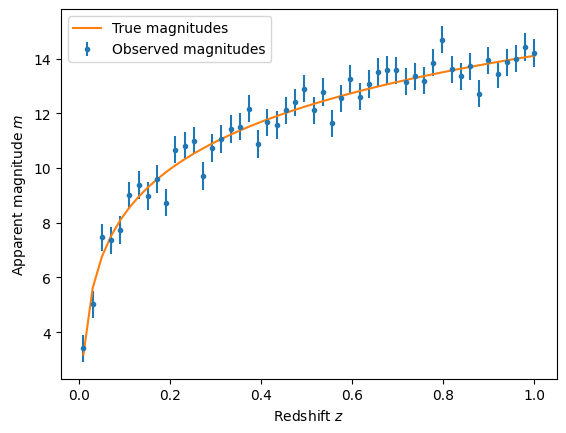

In [6]:
#random seed
np.random.seed(1234)
torch.manual_seed(1234)

# Constants
c = 299792.458  # Speed of light in km/s

# True cosmological parameters
true_Omega_m = 0.3
true_H0 = 70.0  # Hubble constant in km/s/Mpc

# Redshifts of the supernovae
z = np.linspace(0.01, 1.0, 50)

# Noise level in the observed magnitudes
sigma = 0.5

# Luminosity distance function
def luminosity_distance(z, Omega_m, H0):
    """ Calculate the luminosity distance for a given redshift, Omega_m and H0 """
    integrand = lambda z_prime: 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))
    d_L = np.array([quad(integrand, 0, z_i)[0] for z_i in z])
    return (c * (1 + z) * d_L) / H0

# Generate synthetic data
d_L_true = luminosity_distance(z, true_Omega_m, true_H0)
m_true = 5 * np.log10(d_L_true / 10)
m_obs = m_true + np.random.normal(0, sigma, len(m_true))  # Adding Gaussian noise

# Plot synthetic data
plt.errorbar(z, m_obs, yerr=0.5, fmt='.', label='Observed magnitudes')
plt.plot(z, m_true, label='True magnitudes')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()


We will consider a <span style="color:darkorange">uniform prior</span> for $ 0 < \Omega_m < 1$ and $50 < H_0 < 100$, the likelihood function in Eq. $(3)$, and the posterior from the Bayes theorem.

In [7]:
# Log-prior function
def log_prior(params):
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0
    else:
        return -np.inf
    
# Define the log-likelihood function
def log_like(params, z, m_obs):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    sigma_m = 0.5  # Assumed standard deviation of magnitudes
    return -0.5 * np.sum(((m_obs - m_th) / sigma_m)**2)    

# Log-posterior function
def log_post(params, z, m_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, z, m_obs)

Now, we just need to sample from the posterior using MCMC to get the posterior distribution of the parameters $\Omega_m$ and $H_0$.

In [8]:
# Sampling with `emcee` 
ndim, nwalkers = 2, 16
ncpus = multiprocessing.cpu_count()

# Initialize walkers around a random position withing the prior volume
pos = np.random.uniform([0, 50], [1, 100], (nwalkers, ndim))

with Pool(ncpus) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(z, m_obs), pool=pool)
    sampler.run_mcmc(pos, 3000, progress=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:30<00:00, 97.84it/s] 


Removed no burn in


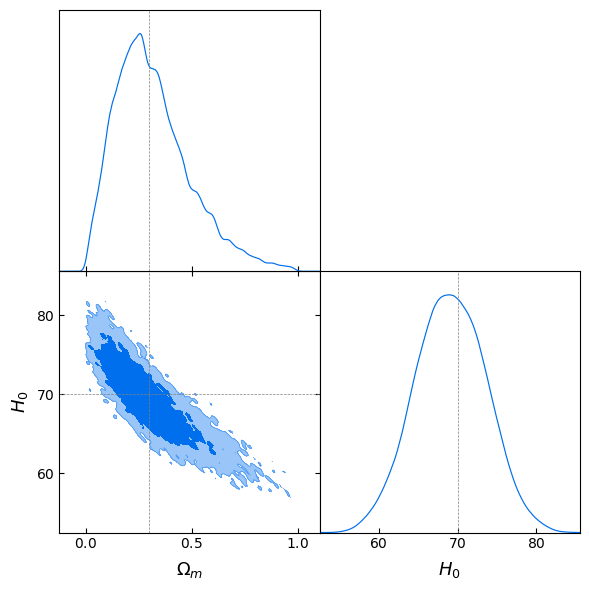

In [9]:
# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

# 4. Simulation-based Inference

Now, let's try to solve the same problem using different simulation-based inference methods. To do this, we'll first need to construct a <span style="color:darkorange">simulator for the luminosity distance to supernovae</span>.

In [10]:
# noise level
sigma = 0.5

# Forward model to simulate observed magnitudes
def luminosity_distance_simulator(params, z):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    m_sim = m_th + np.random.normal(0, sigma, len(m_th))
    return m_sim

This very simple simulator uses the theoretical model for the luminosity distance given by Eq. $(2)$ and $(1)$ to generate the theoretical apparent magnitudes $m_{\text{th}}$ for a given set of cosmological parameters $\Omega_m$ and $H_0$, and adds Gaussian noise to generate the observed apparent magnitudes $m_{\text{obs}}$.

## 4.1. Traditional SBI - Approximate Bayesian Computation (ABC)

The first simulation-based inference method we'll use is ABC. ABC was one of the first simulation-based inference methods developed and is based on the idea of <span style="color:darkorange">approximating the posterior</span> distribution by <span style="color:darkorange">sampling from the prior</span> distribution and <span style="color:darkorange">accepting samples that are "close enough" to the observed data</span>.

General procedure:
1. **Sample** parameters from the prior distribution $\theta \sim p(\theta)$.
2. **Forward simulate** these parameters to generate **synthetic observations** $x \sim p(x | \theta)$.
3. **Compare** the synthetic observations to the real observed data $x_{\text{obs}}$ using a distance metric $d(x, x_{\text{obs}})$.
4. If the synthetic observations are "close enough" to the real observed data, i.e., $d(x, x_{\text{obs}}) < \epsilon$ for some threshold $\epsilon$, **accept the parameters** $\theta$ as samples from the posterior $p(\theta | x_{\text{obs}})$.

ABC does not require the likelihood function to be known, instead the likelihood is approximated by the probability that the condition $d(x, x_{\text{obs}}) < \epsilon$ is satisfied.

As the threshold $\epsilon \to 0$, the accepted samples converge to the true posterior. For $\epsilon > 0$, the inferred posterior will be broader than the true posterior, therefore the inference will be conservative.

<center><img src="assets/abc.png" width="800" />

<small> <i>Figure 6:</i> Approximate Bayesian computation (ABC) algorithm. The simulator is used to generate synthetic data $x \sim p(x | \theta)$ for a range of parameters $\theta$. The distance function $d(x, x_{\text{obs}})$ is used to compare the synthetic data to the observed data. Image credit: Siddharth Mishra-Sharma.
 </small>
</center>

Let's now try to apply ABC to our problem of inferring the cosmological parameters $\Omega_m$ and $H_0$ from supernova data. As a distance metric, we'll use the mean squared error (MSE), $d(x, x_{\text{obs}}) = \frac{1}{N} \sum_{i=1}^N (x_i - x_{\text{obs},i})^2$, between the observed apparent magnitudes $m_{\text{obs}}$ and the synthetic apparent magnitudes $m_{\text{th}}$.

In [27]:
# Distance metric: Mean Squared Error
def mse(x, x_sim):
    return np.sum((x - x_sim) ** 2) / len(x)

# ABC Algorithm
def abc(y, x, eps_thresh=0.5, num_samples=1000):
    """ Approximate Bayesian Computation (ABC) algorithm """
    accepted_samples = []
    trials = 0
    progress_bar = tqdm(total=num_samples, desc=f"Accepted Samples (eps={eps_thresh})")

    while len(accepted_samples) < num_samples:
        params = np.random.uniform(low=[0, 50], high=[1, 100])  # θ ~ p(θ) (Step 1)
        x_sim = luminosity_distance_simulator(params, y)  # x ~ p(x|θ) (Step 2)
        eps = mse(x, x_sim)  # Distance metric; d(x, x_sim) (Step 3)
        trials += 1

        # If accepted, add to samples (Step 4)
        if eps < eps_thresh:
            accepted_samples.append(params) 
            acceptance_ratio = len(accepted_samples) / trials 
            progress_bar.update(1)
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    
    return np.array(accepted_samples)

We will run the ABC algorithm for two different values of $\epsilon$: $0.4$ and $0.6$.

In [28]:
# Run ABC
eps_thresh = [0.4, 0.6]

# Run ABC for each epsilon threshold
results = {}
for eps in eps_thresh:
    results[eps] = abc(z, m_obs, eps_thresh=eps, num_samples=3000)

Accepted Samples (eps=0.4):   0%|          | 4/3000 [00:00<00:59, 50.53it/s, acceptance_ratio=0.041]

Accepted Samples (eps=0.6): 100%|██████████| 3000/3000 [00:06<00:00, 450.00it/s, acceptance_ratio=0.372]


Removed no burn in
Removed no burn in


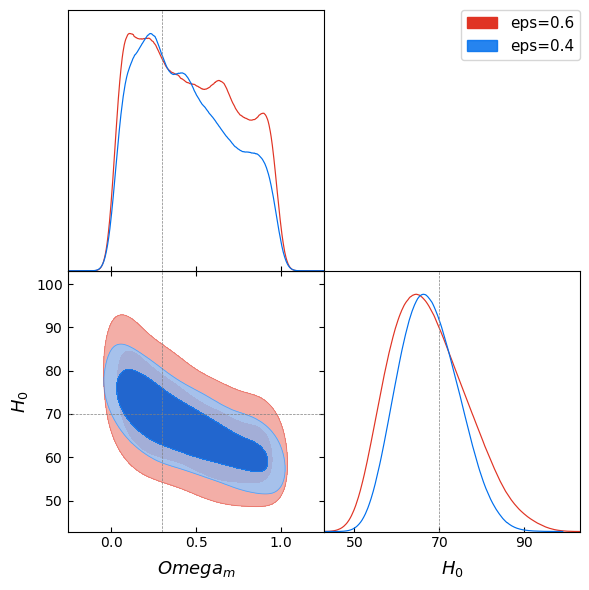

In [29]:
# GetDist plotting
samples1 = MCSamples(samples=results[0.6], names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])
samples2 = MCSamples(samples=results[0.4], names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples1, samples2], filled=True, markers={'Omega_m': true_Omega_m, 'H0': true_H0}, legend_labels=[f"eps={eps_thresh[1]}", f"eps={eps_thresh[0]}"])
plt.show()

We see that first of all, the posteriors that we get from ABC are reasonably close to the "true" posterior that we got from standard Bayesian inference. However, as expected, the posteriors from ABC are broader than the true posterior, because of the relatively large values of $\epsilon$ that we used, and indeed, the bigger the $\epsilon$, the broader the posterior.

**Drawbacks of ABC:**
- We need to <span style="color:darkorange">choose a distance metric</span> that is appropriate for the problem.
- We have an <span style="color:darkorange">extra hyperparameter</span> to tune: the threshold $\epsilon$.
- Small values of $\epsilon$ <span style="color:darkorange">require unfeasibly many simulations</span>, while large values lead reduced accuracy.
- The sample efficiency of ABC <span style="color:darkorange">scales poorly to high-dimensional</span> data $x$ and high-dimensional parameters $\theta$.
- Inference for new data or different choice of prior requires <span style="color:darkorange">re-running the entire algorithm</span>.

# Sample generation & normalization

All the methods that we will see next, are based on Neural Networks, and to train them, we need to generate a large number of samples from the simulator. So let's sample from the prior distribution of the parameters $\theta$ and then simulate the data $x$ for each of these parameters:

In [11]:
np.random.seed(1234) # use random seed for reproducibility

# Generate training data
n_train = 50_000
param_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_train, 2)) # Parameter proposal
x_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(param_samples)])

# Convert to tensors
param_samples = torch.tensor(param_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

100%|██████████| 50000/50000 [00:33<00:00, 1485.74it/s]


In machine learning, it is common to normalize the input data to have zero mean and unit variance. This helps the neural network to learn more efficiently:

In [12]:
def normalize(data):
    """ Normalizes the data to have mean 0 and standard deviation 1. """
    mean = data.mean(dim=0)
    std = data.std(dim=0)
    return (data - mean) / std, mean, std

In [13]:
# Normalize the training data
x_norm, x_mean, x_std = normalize(x_samples)
param_norm, param_mean, param_std = normalize(param_samples)

Check one of the generated samples:

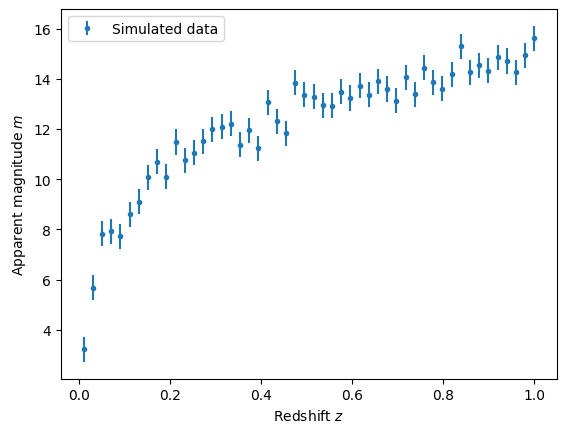

In [14]:
# plot the training data
plt.errorbar(z, x_samples[49999], yerr=sigma, fmt='.', label='Simulated data')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()

## 4.2. Neural Posterior Estimation (NPE)

This method is a Deep Learning implementation of ***density estimation***: given a set of points $\{x\} \sim \mathcal{P}(x)$, we want to learn the distribution $\mathcal{P}(x)$.

The way that we would normally do this for inference is by creating a model for the likelihood via estimating the distribution of the simulated data using <span style="color:darkorange">histograms</span> or <span style="color:darkorange">kernel density estimation</span>. However, these methods are not very flexible and **do not scale well to high-dimensional data** (curse of dimensionality).

This is where recent advances in <span style="color:darkorange">density estimation techniques using neural networks</span> come in. 

<!-- add dashed line --> 
>To understand how neural networks can be used for density estimation, let's first consider a simple example where we want to estimate the **distribution** over $\theta$, in the case when this distribution is a 1D Gaussian. Here, we can use a neural network to model the mean and variance of the Gaussian as a function of some input $x$:
>$$ p(\theta | x) = \mathcal{N}\big(\mu = f(x), \sigma = g(x)\big),$$
>where $f(x)$ and $g(x)$ are the outputs of the neural network. The neural network will be trained to maximize the likelihood of this predicted Gaussian over the training data by tuning the parameters of $f$ and $g$.

However, in general, we do not expect the posterior to be Gaussian. In this case, we can use a more general neural network architecture to model the posterior.
One class of these neural density estimation methods is **Normalizing Flows**.

### 4.2.1. Interlude: Normalizing Flows
Normalizing Flows are <span style="color:darkorange">invertible transformations</span> of the probabilistic space that allows to <span style="color:darkorange">map a simple distribution to a more complex one</span>.

<center> <img src="assets/normalizing-flow.png" width="800" /> 

<small> <i>Figure 7:</i> Illustration of a normalizing flow model, transforming a simple distribution $p_0(z_0)$ (left) to a complex one $p_K(z_K)$ (right) through a series of invertible transformations $f_k$. Image credit: Lilian Weng.
 </small>
</center>

The key idea behind Normalizing Flows is to start with a <span style="color:darkorange">simple base distribution</span> $\pi(\mathbf{u})$ (e.g. a standard normal) and **transform** it through a series of <span style="color:darkorange">invertible transformations</span> $f$ (bijections) to obtain a more <span style="color:darkorange">complex target distribution</span> $p(\mathbf{u})$. This is formalized using the change of variables formula:
$$ \mathbf{z} \sim \pi(\mathbf{u}), \quad \mathbf{x} = f(\mathbf{u}), \quad \mathbf{u} = f^{-1}(\mathbf{x}) $$
$$ p(\mathbf{x}) = \pi(\mathbf{u}) \left| \det \frac{d\mathbf{u}}{d\mathbf{x}} \right| = \pi(f^{-1}(\mathbf{x})) \left| \det \frac{df^{-1}(\mathbf{x})}{d\mathbf{x}} \right|$$

where $f^{-1}$ is the inverse transformation of $f$, and the Jacobian determinant $\left| \det \frac{df^{-1}(\mathbf{x})}{d\mathbf{x}} \right|$ accounts for the change in volume when transforming from $\mathbf{u}$ to $\mathbf{x}$ space. The Jacobian ensures that the transformation is <span style="color:darkorange">volume-preserving</span>, so that the transformed density $p(\mathbf{x})$ integrates to 1. So Normalizing Flows allow constructing expressive distributions by composing simple, invertible transformations.

The challenge is in designing mappings $f$ that are both: **easy to invert** and **easy to compute the Jacobian of**.

Miles Cranmer puts it nicely:
- There's a crowd of people; each is a sample of the data distribution.
- Everybody takes a step in some direction according to a neural net
- In steps, the net tries to direct the crowd to form a Gaussian without bumping each other

<center> 
<img src="assets/forward.gif" /> 

<small> The NF transforms the simple base distribution to the target distribution by applying a series of invertible transformations one after the other. Image credit: Eric Jang.
</small> 
</center> 

<details>
<summary><span style="color:red">Coupling Layers <em>(Open at your own risk)</em></span></summary>

#### Coupling layers

One of the most popular building blocks for Normalizing Flows are coupling layers. A coupling layer splits the input $x$ into two parts $(x_1, x_2)$, and transforms one part (say $x_2$) as a function of the other:
$$x_2' = x_2 \odot \exp(s(x_1)) + t(x_1),$$
where $s(x_1)$ and $t(x_1)$ are the scale and translation functions, which are implemented as **neural networks**, and $\odot$ denotes element-wise multiplication. The other part $x_1$ remains unchanged. This transformation is both **invertible** and has a **simple Jacobian determinant**. The inverse transformation is given by:
$$x_2 = (x_2' - t(x_1)) \odot \exp(-s(x_1)).$$
Stacking coupling layers with different partitions of the input allows information to flow between all dimensions. This gives Normalizing Flows the flexibility to model complex distributions while maintaining tractability.

</details>

<details>
<summary><span style="color:red">Training a Normalizing Flow <em>(Open at your own risk)</em> </span></summary>

#### Training

Normalizing Flows are trained to **maximize the likelihood of training data $x$ under the transformed distribution $p(x)$**. This is equivalent to minimizing the Kullback-Leibler divergence between the data and model distributions.

> **Kullback-Leibler (KL) divergence** measures the difference between two probability distributions $p(x)$ and $q(x)$:
> $$ D_{KL}(p||q) = \mathbb{E}_{p(x)}\left[\log \frac{p(x)}{q(x)}\right] = \int p(x) \log \frac{p(x)}{q(x)} dx.$$
> The KL divergence is non-negative and is zero if and only if $p(x) = q(x)$.
> Minimizing the KL divergence is equivalent to maximizing the likelihood of the data under the model distribution.

So let's see exactly how we would train a Normalizing Flow to estimate the posterior $p(\theta | x)$. So far, we have the tools to emulate a probability distribution with a neural network. We'll write such a probability distribution $q_\phi$ where $\phi$ are the parameters of the neural network. 

A way to learn the distribution $p(\theta | x)$ with a Neural Network with weights $\phi$ is to minimize $D_{KL}\Big(p(\theta | x) || q_\phi(\theta | x)\Big)$ w.r.t.the NN parameters $\phi$. Let's do the math:
$$ D_{KL}\Big(p(\theta | x) || q_\phi(\theta | x)\Big) = \mathbb{E}_{p(\theta | x)}\left[\log \frac{p(\theta | x)}{q_\phi(\theta | x)}\right] $$
However, we want our model to work for different values of $x$, so we need to take the expectation of this expression w.r.t. $p(x)$:

\begin{align*}
\mathbb{E}_{p(x)} \Big[ D_{KL}\big(p(\theta | x) || q_\phi(\theta | x)\big) \Big] &= \mathbb{E}_{p(x)}\mathbb{E}_{p(\theta | x)}\left[\log \frac{p(\theta | x)}{q_\phi(\theta | x)}\right] = \mathbb{E}_{p(\theta,x)}\left[\log \frac{p(\theta | x)}{q_\phi(\theta | x)}\right] \\\\
&= \mathbb{E}_{p(\theta,x)} \left[ - \log q_\phi(\theta | x)\right] + \mathrm{const}_{w.r.t. \phi}
\end{align*}

where in the second equality we used $p(\theta,x) = p(\theta | x)p(x)$.
Therefore, to optimize our neural network, we need to minimize:
$$ \min_\phi \mathbb{E}_{p(x)} \Big[ D_{KL}\big(p(\theta | x) || q_\phi(\theta | x)\big) \Big] = \min_\phi \mathbb{E}_{p(\theta,x)} \left[ - \log q_\phi(\theta | x)\right] + \cancel{\mathrm{const}_{w.r.t. \phi}}$$
which we can estimate since we have samples from $p(\theta,x)$ from the simulator!

<center>
<img src="assets/monty_python.gif" width="400px" />
</center>

</details>

Once we have trained the Normalizing Flow, we can sample the model $q_\phi(\theta | x_{\text{obs}})$ directly to obtain samples from the approximate posterior distribution $p(\theta | x_{\text{obs}})$. To do this, we simply sample $z$ from the base distribution (e.g. a standard normal) and apply the inverse transformation $f^{-1}$ to obtain samples from the posterior.

#### Normalizing Flows summary:
1. Start from a <span style="color:darkorange">simple base distribution</span> that is easy to sample from and evaluate the density of, like a standard normal.

2. Apply a <span style="color:darkorange">sequence of invertible transformations</span> to this base distribution. Each transformation is designed to be efficient to compute and have a tractable Jacobian.

3. The transformed distribution at the end of this sequence of transformations is the <span style="color:darkorange">final Normalizing Flow distribution</span>. It can be much more complex and expressive than the base distribution.

4. <span style="color:darkorange">Sampling</span> from the Normalizing Flow is <span style="color:darkorange">efficient</span> - just sample from the base distribution and pass it through the sequence of transformations. <span style="color:darkorange">Evaluating the density of a point</span> is also <span style="color:darkorange">tractable</span> using the change of variables formula.

5. The transformations are <span style="color:darkorange">parameterized</span> by <span style="color:darkorange">neural networks</span> and <span style="color:darkorange">trained to maximize the likelihood of observed data</span>. This allows learning complex, data-driven distributions.

> If you want to learn more about Normalizing Flows, you can check out the paper by [Papamakarios et al. (2019)](https://arxiv.org/abs/1912.02762) and the blog post by [Lilian Weng](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html).

### 4.2.2. Back to NPE

Now that we are OK with Normalizing Flows, let's see the specifics of how we can use them for Neural Posterior Estimation.
The steps of the algorithm are:
1. **Generate training data**: Sample a large number of parameter values $\theta$ from the prior, run the simulator to generate corresponding data $x$, and store the $(\theta, x)$ pairs as training data.

2. [Optional] **Feature extraction**: Extract features from the data $x$ using a neural network $s_\varphi(x)$. This is useful when the data $x$ is high-dimensional or complex, and we want to reduce its dimensionality or complexity. What the NN does is essentially to learn a compressed representation of the data that is useful for the inference task. For now, you can forget about this and just consider $s_\varphi(x) = x$.

3. **Training the conditional density estimator**: 
    - evaluate the log-density of the NF, $\log q_\phi(\theta | x)$, at the training data points $(\theta, x)$.
    - wiggle the parameters $\phi$ of the NF until the log-likelihood of the training data is maximized.
    - the exact loss function is: $$\mathcal{L}(\phi, \varphi) = -\frac{1}{N} \sum_{i=1}^N \log q_\phi(\theta_i | s_\varphi(x_i)),$$ where $N$ is the number of training samples, and $\{ \phi, \varphi \}$ are the parameters of the NF and the feature extractor, respectively.
    
4. **Inference**: To perform inference for new data $x_{\text{obs}}$, just sample from the NF model $q_\phi(\theta | x_{\text{obs}})$ to obtain samples from the posterior distribution $p(\theta | x_{\text{obs}})$!

<center>
<img src="assets/npe.png" width="800" />

<small> <i>Figure 8:</i> Neural Posterior Estimation (NPE) algorithm. The simulator is used to generate synthetic data $x$ for a range of parameters $\theta$. The NF is trained to model the posterior distribution $p(\theta | x)$ conditioned on the training data. Image credit: Siddharth Mishra-Sharma.
 </small>

</center>

### 4.2.3. Applying NPE to our problem

We will first define a simple MLP, which we will use as the feature extractor $s_\phi(x)$ in the NPE algorithm, to reduce the dimensionality of the data $x$. Again, don't worry too much about this for now, just consider $s_\phi(x) = x$.

In [15]:
def build_mlp(input_dim, hidden_dim, output_dim, num_layers, activation=nn.GELU()):
    """Builds a multi-layer perceptron (MLP) neural network."""
    layers = [nn.Linear(input_dim, hidden_dim), activation]  # First layer and activation
    
    for _ in range(num_layers):
        layers += [nn.Linear(hidden_dim, hidden_dim), activation] # Hidden layers and activations
        
    layers += [nn.Linear(hidden_dim, output_dim)] # Output layer
    
    return nn.Sequential(*layers)

#### NPE class

Now the important part: we will define our conditional Normalizing Flow model that will learn the posterior distribution $p(\theta | x)$.
> The NF will be trying to model the distribution of the *parameters* $\theta$ given the **context** (condition) of the *data* $x$.

In [16]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """
    Neural Posterior Estimator using a normalizing flow as the posterior density estimator.

    Parameters:
        featurizer (nn.Module): Neural network for feature extraction.
        d_context (int): Dimension of the context vector.
    """
    
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer # Featurizer network for context extraction
        self.flow = self._build_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4) # Normalizing flow
    
    def _build_flow(self, d_in, d_hidden, d_context, n_layers):
        """ Instantiate a normalizing flow with Masked Autoregressive Transformations. """
        base_dist = StandardNormal(shape=[d_in]) # base distribution of NF = standard normal 
        transforms = [] # List to hold the series of transformations
        
        for _ in range(n_layers):
            # Reverse permutation to shuffle the features
            transforms.append(ReversePermutation(features=d_in))
            
            # Masked Autoregressive Transform for flexible and expressive transformations
            transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
            
        # Combine all transformations into a composite transform
        transform = CompositeTransform(transforms)
        
        return Flow(transform, base_dist)    

    def forward(self, x):
        return self.featurizer(x) # Extract features using the featurizer
    
    def loss(self, x, params):
        context = self(x)  # Extract context from x using the featurizer
        return -self.flow.log_prob(inputs=params, context=context) # Compute negative log probability

    def training_step(self, batch):
        x, params = batch 
        loss = self.loss(x, params).mean()  # Compute mean loss
        self.log("train_loss", loss) # Log the training loss
        return loss

    def validation_step(self, batch):
        x, params = batch
        loss = self.loss(x, params).mean() # Compute mean validation loss
        self.log("val_loss", loss) # Log the validation loss
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4) 

Instantiate the featurizer and NeuralPosteriorEstimator

In [17]:
featurizer = build_mlp(input_dim=50, hidden_dim=128, output_dim=16, num_layers=4)
npe = NeuralPosteriorEstimator(featurizer=featurizer, d_context=16)

Create the dataset and dataloader, using the PyTorch DataLoader class:

In [18]:
val_fraction = 0.1 # Fraction of data to use for validation
batch_size = 128 
n_samples_val = int(val_fraction * len(x_norm)) 

dataset = TensorDataset(x_norm, param_norm) 
dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val]) 

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

Train the model:

In [19]:
trainer = pl.Trainer(max_epochs=20, accelerator="cpu")
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/atersenov/miniconda3/envs/astrostat24/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | featurizer | Sequential | 74.6 K | train
1 | flow       | Flow       | 24.3 K | train
--------------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/atersenov/miniconda3/envs/astrostat24/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/atersenov/miniconda3/envs/astrostat24/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 352/352 [00:07<00:00, 50.13it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 352/352 [00:07<00:00, 50.07it/s, v_num=2]


We have trained the Normalizing Flow model to estimate the posterior distribution $p(\theta | x)$ given **any** observed data $x$! We can now sample from this model to obtain samples from the posterior distribution for $\Omega_m$ and $H_0$.

#### Inference

So let's generate a mock observed data $x_{test} = x_{\text{obs}}$ and sample from the model to obtain samples from the posterior distribution $p(\theta | x_{\text{obs}})$. Don't get confused - in a real application, $x_{\text{obs}}$ would be the actual observed data, and we would use the model to infer the posterior distribution of the parameters $\theta$ given this data.

In [20]:
# Test the trained model
param_test = np.array([0.3, 70.0])
x_test = luminosity_distance_simulator(param_test, z) # assume that the observed data "comes from" the above parameters

x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std # normalize the test data
context = npe.featurizer(x_test_norm).unsqueeze(0)

In [21]:
# Sample from the trained normalizing flow
test_samples = npe.flow.sample(num_samples=10000, context=context) * param_std + param_mean
test_samples = test_samples.detach().numpy().squeeze(0)

Removed no burn in


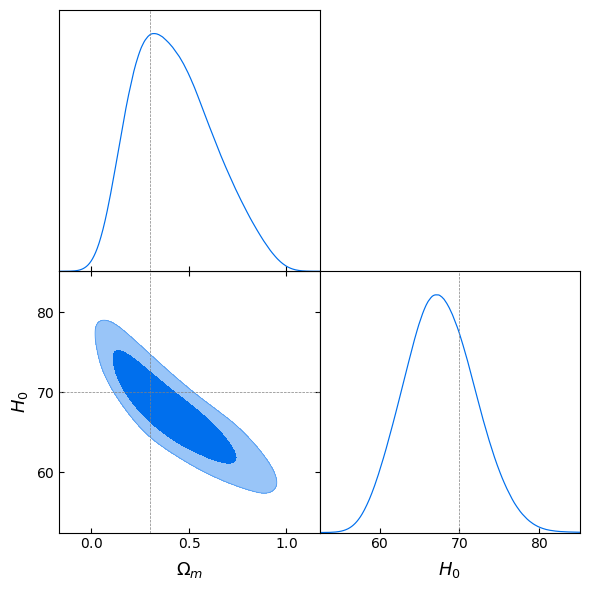

In [22]:
# Create a MCSamples instance
samples = MCSamples(samples=test_samples, labels=['\Omega_m', 'H_0'], names=['Omega_m', 'H_0'])

true_Omega_m = 0.3
true_H0 = 70

# Create a GetDist plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples], filled=True, markers={'Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

We see that the posteriors that we get from NPE are very similar to the "true" posterior that we got from standard Bayesian inference!

**Advantages of NPE:**
- No need for a <span style="color:darkorange">likelihood</span> function.
- Get direct samples from the <span style="color:darkorange">posterior</span>.
- <span style="color:darkorange">Flexible posterior modeling</span> with Normalizing Flows.
- <span style="color:darkorange">Scalable to high-dimensional</span> data and parameters: Normalizing Flows allow NPE to scale to high-dimensional parameter and data spaces.
- <span style="color:darkorange">Amortized inference</span>: Once the NF model is trained on simulated data, it can quickly produce posterior samples for any new observed data $x_{obs}$ through a simple forward pass. This means that we don't need to re-run the inference algorithm for new data.

**Drawbacks of NPE:**
- We must <span style="color:darkorange">retrain</span> the model if we want to change the prior.
- If the prior and the posterior are <span style="color:darkorange">very different</span>, the model may not be able to capture the posterior distribution well.
- Still, in <span style="color:darkorange">high-dimensional spaces</span>, the model may struggle to capture the posterior distribution accurately if we don't have a huge amount of training data.


### 4.2.4. Coverage Test

To check the accuracy of our approximate SBI methods it is important to have additional tests, that <span style="color:darkorange">don't require having a ground-truth</span> against which to compare the results. Fortunately, SBI allows us to perform tests like this, with the most common one being the **coverage test**.

Coverage is defined as the <span style="color:darkorange">proportion of times the true parameter values fall within the specified credible intervals</span> of the posterior distributions. Ideally, a $95\%$ credible interval should contain the true parameter value $95\%$ of the time. If our intervals are too narrow, we might be overconfident, whereas if they're too wide, we might be conservative.

This test uses the fact that once the inference network is trained, it can <span style="color:darkorange">generate the posteriors for *any* mock observed data</span> simulated from the prior, (as opposed to standard Bayesian inference with MCMC, where we can only generate posteriors for a single set of observed data). Therefore, we can perform the following test:
1. Generate a large number of mock observed data $x_{\text{test}}$ from the prior.
2. For each $x_{\text{test}}$, generate samples from the posterior $p(\theta | x_{\text{test}})$ using the trained inference network.
3. Check if the true parameter values $\theta_{\text{true}}$ are within the e.g. 95% credible interval of the posterior samples for each $x_{\text{test}}$.
4. The coverage is the fraction of $x_{\text{test}}$ for which $\theta_{\text{true}}$ is within the 95% credible interval.

> High Posterior Density (HPD) credible intervals are the shortest credible intervals that contain a certain percentage of the posterior probability. In other words, the HPD interval is the shortest interval that contains the true parameter value with a certain probability.

In [ ]:
# Generate test samples
n_test = 1000
param_test_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_test, 2))
x_test_samples = np.array([luminosity_distance_simulator(params, z) for params in tqdm(param_test_samples)])

# Normalize test data
x_test_samples_norm = (torch.tensor(x_test_samples, dtype=torch.float32) - x_mean) / x_std

# Featurize test data to get the context for the normalizing flow
context = npe.featurizer(x_test_samples_norm)

# Sample `num_samples`(1000) parameter values from the posterior for each test data point
samples_test = npe.flow.sample(num_samples=1000, context=context) * param_std + param_mean # denormalize the samples
samples_test = samples_test.detach().numpy()

100%|██████████| 1000/1000 [00:01<00:00, 825.86it/s]


Now, let's define our High Posterior Density (HPD) function. The way we will calculate the HPD is by sorting the posterior samples and finding the shortest interval that contains `credible_mass` ratio of the samples.

In [ ]:
def HPD(samples, credible_mass=0.95):
    """
    Compute the highest posterior density (HPD) interval of the given samples for a given credible mass.
    
    Args:
        samples (np.ndarray): Array of samples.
        credible_mass (float): The desired credible mass for the HPD interval.
        
    Returns:
        (float, float): The lower and upper bounds of the HPD interval.
    """
    sorted_samples = np.sort(samples) # Sort the samples in ascending order
    interval_idx_inc = int(np.floor(credible_mass * len(sorted_samples))) # Number of samples to include in the interval
    n_intervals = len(sorted_samples) - interval_idx_inc # Number of intervals
    interval_width = sorted_samples[interval_idx_inc:] - sorted_samples[:n_intervals] # Width of each interval
    min_idx = np.argmin(interval_width) # Index of the interval with the smallest width
    hdi_min = sorted_samples[min_idx] # Lower bound of the HPD interval
    hdi_max = sorted_samples[min_idx + interval_idx_inc] # Upper bound of the HPD interval
    return hdi_min, hdi_max

Assess empirical coverage

In [ ]:
p_nominals = np.linspace(0.01, 0.99, 50) # Use 50 different nominal coverage values, ranging from 1% to 99%
contains_true = np.zeros((2, len(p_nominals)))

# For each parameter and test sample, compute the HPD interval for different nominal coverages 
# and check if the true parameter value falls within the interval.
for i_param in range(2): 
    for i, sample in enumerate(samples_test[:, :, i_param]):
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = HPD(sample, credible_mass=p_nominal)
            if hdi_min < param_test_samples[i, i_param] < hdi_max:
                contains_true[i_param, j] += 1

# Calculate the empirical coverage 
# (count the number of times the true parameter value is contained within the HPD interval for each nominal coverage)
empirical_coverage = contains_true / n_test

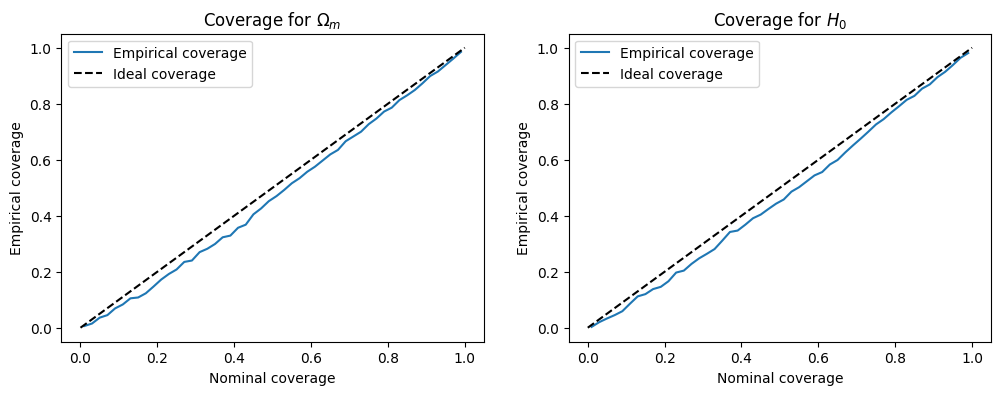

In [ ]:
# Plot the coverage
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

param_names = ["$\Omega_m$", "$H_0$"]
for i in range(2):
    ax[i].plot(p_nominals, empirical_coverage[i], label='Empirical coverage')
    ax[i].plot([0, 1], [0, 1], color="black", linestyle="--", label='Ideal coverage')
    ax[i].text(0.1, 0.8, "Conservative")
    ax[i].text(0.6, 0.1, "Overconfident")
    ax[i].set_xlabel("Nominal coverage")
    ax[i].set_ylabel("Empirical coverage")
    ax[i].set_title(f"Coverage for {param_names[i]}")
    ax[i].legend()

plt.show()

We see that the empirical coverage is quite close to the ideal coverage (diagonal line), which means that the posteriors that we get from NPE are quite accurate, if slightly overconfident.

# Neural Ratio Estimation (NRE)

This method implements a Neural Network to estimate the likelihood ratio 
$$r(x ; \theta ) = \frac{p(x | \theta)}{p(x)}$$
instead of the posterior distribution $p(\theta | x)$.
The likelihood ratio is a key quantity in Bayesian inference, as it allows us to compute the posterior distribution by simply weighting it by the prior distribution.

Let's go through the steps of the NRE algorithm:
1. **Generate training data 1**: Sample a large number of parameter values $\theta$ from the prior $p(\theta)$, run the simulator to generate corresponding data $x$, and store the $(\theta, x)$ pairs as training data. This way, those data-parameter pairs are drawn from the joint distribution $p(\theta, x) = p(\theta)p(x | \theta)$.

2. **Generate training data 2**: By *randomly shuffling* the components of data-parameter pairs we generated above, we can get a second set of training data $(\theta, x)$, which are drawn from the product of the marginal distributions $p(\theta)p(x)$.

3. **Training a classifier to compute the likelihood ratio**: 
    - Assign labels to the training data from the two classes: $y=0$ for the first set of training data that is drawn from $p(\theta, x)$, and $y=1$ for the second set of training data that is drawn from $p(\theta)p(x)$.
    - Train a binary classifier $d_\phi (x, \theta)$ to distinguish between  samples drawn from the joint and the product of marginals: $$ d_{\phi}(x, \theta) \approx \begin{cases} 1 & \text{if } (x, \theta) \sim p(x, \theta) \\ 0 &
						\text{if } (x, \theta) \sim p(x)p(\theta) \end{cases} $$
    - The trained classifier will approximate $$ d_\phi(x,\theta) \approx d_\phi^*(x, \theta) = \sigma\left( \log r(x ; \theta) \right)= \frac{p(x, \theta)}{p(x,\theta) + p(x)p(\theta)} = \frac{1}{1 + r^{-1}(x ; \theta)}$$ where $\sigma = \left[ 1 + \exp(-x) \right]^{-1}$ is the sigmoid function. This can be shown by analytically minimizing the binary cross-entropy loss, which is the loss function used to train the classifier: $$\mathcal{L}(\phi) = -\mathbb{E}_{p(x, \theta)}\left[\log d_\phi(x, \theta)\right] - \mathbb{E}_{p(x)p(\theta)}\left[\log (1 - d_\phi(x, \theta))\right].$$
    - Therefore, the likelihood ratio will be estimated as $$ r(x ; \theta) = \frac{p(x | \theta)}{p(x)} \approx \frac{d_\phi(x, \theta)}{1 - d_\phi(x, \theta)} = \hat{r}(x ; \theta).$$

4. **Inference**: To perform inference for new data $x_{\text{obs}}$, we can use the estimated likelihood ratio $\hat{r}(x ; \theta)$ to compute the posterior distribution $p(\theta | x_{\text{obs}})$: $$ p(\theta | x_{\text{obs}}) = \hat{r}(x_{\text{obs}} ; \theta) \, p(\theta) .$$    

<center><img src="assets/nre.png" width="800" /></center>

#### Application to the supernova problem

So let's define the Neural Ratio Estimator class for our problem. The classifier that we will use to estimate the likelihood ratio will be the simple MLP that we had defined earlier, however, this time it will be trained to classify between the two classes of data-parameter pairs.

In [ ]:
class NeuralRatioEstimator(pl.LightningModule):
    """
    Neural Ratio Estimator using a multi-layer perceptron (MLP).

    Parameters:
        x_dim (int): Dimension of the input data.
        param_dim (int): Dimension of the parameter space.
    """
    def __init__(self, x_dim, param_dim):
        super().__init__()
        # Build MLP model with input dimensions from data and parameters
        self.mlp = build_mlp(input_dim=x_dim + param_dim, hidden_dim=128, output_dim=1, num_layers=4)

    def forward(self, x):
        return self.mlp(x)
    
    def loss(self, x, params):
        # Repeat x in groups of 2 along batch axis
        x_repeated = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        params_shuffled = params[torch.randperm(params.shape[0])]

        # Interleave theta and shuffled theta
        params_combined = torch.stack([params, params_shuffled], dim=1).reshape(-1, params.shape[1])

        # Create labels: 1 for original pairs (joint), 0 for shuffled pairs (marginals)
        labels = torch.ones(x_repeated.shape[0], device=x.device)
        labels[1::2] = 0.0

        # Compute logits from the MLP and apply sigmoid for probabilities
        logits = self(torch.cat([x_repeated, params_combined], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)  # Return binary cross-entropy loss


    def training_step(self, batch):
        x, params = batch
        loss = self.loss(x, params).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch):
        x, params = batch
        loss = self.loss(x, params).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [ ]:
# Initialize the model
model = NeuralRatioEstimator(x_dim=50, param_dim=2)

# Evaluate initial loss on a small sample
initial_loss = model.loss(x_norm[:64], param_norm[:64]).mean().item()
print(f"Initial loss: {initial_loss}")

Initial loss: 0.6931858062744141


In [ ]:
from torch.utils.data import DataLoader, random_split, TensorDataset

# Create dataset and dataloaders
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_norm, param_norm)
dataset_train, dataset_val = random_split(dataset, [len(x_norm) - n_samples_val, n_samples_val])

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

# Train the model
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/tersenov/anaconda3/envs/astrostat24/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tersenov/anaconda3/envs/astrostat24/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | mlp  | Sequential | 73.0 K | train
--------------------------------------------
73.0 K    Trainable params
0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
def log_prior(params):
    """ Log-prior distribution for the parameters. """
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0.0  # Uniform prior
    else:
        return -np.inf  # Log(0) for invalid values
    
def log_like(params, x):
    """ Log-likelihood ratio estimator using trained classifier logits. """
    x = torch.Tensor(x)
    params = torch.Tensor(params)

    # Normalize
    x = (x - x_mean) / x_std
    params = (params - param_mean) / param_std

    x = torch.atleast_1d(x)
    params = torch.atleast_1d(params)

    return model.mlp(torch.cat([x, params], dim=-1)).squeeze()

def log_post(params, x):
    """ Log-posterior distribution for the parameters given the observed data. """
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        #return torch.tensor().detach().numpy( lp + log_like(theta, x) )
        return (lp + log_like(params, x)).detach().numpy()

In [ ]:
# Generate synthetic test data
params_test = np.array([0.3, 70.0])
x_test = luminosity_distance_simulator(params_test, z)

In [ ]:
# Run MCMC sampling
ndim, nwalkers = 2, 32
ncpus = multiprocessing.cpu_count()

pos = params_test + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))
sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:55<00:00, 89.30it/s]


State([[9.45093006e-01 5.71504184e+01]
 [7.21830389e-01 6.47511810e+01]
 [5.04442856e-01 6.20810755e+01]
 [2.07643945e-01 7.18051614e+01]
 [7.63294402e-01 6.00820709e+01]
 [6.93561882e-01 6.32770603e+01]
 [8.50115324e-01 5.91514884e+01]
 [4.08040560e-01 6.46144497e+01]
 [3.44041229e-01 6.59234542e+01]
 [1.87284636e-01 7.43231686e+01]
 [6.38095660e-01 6.18611587e+01]
 [3.65587602e-01 6.92351492e+01]
 [3.91821787e-01 6.86034498e+01]
 [7.52158715e-01 6.53186493e+01]
 [7.03908283e-01 6.38778664e+01]
 [6.84793703e-01 6.08872772e+01]
 [7.30175239e-02 7.42610558e+01]
 [1.39430414e-01 7.58072723e+01]
 [2.93999358e-01 6.75046813e+01]
 [5.03758035e-01 6.18929552e+01]
 [4.14409575e-01 6.69366468e+01]
 [6.91316249e-01 6.62721211e+01]
 [2.21900583e-01 7.49273469e+01]
 [3.81675747e-01 6.44225030e+01]
 [2.88704614e-01 7.18655291e+01]
 [3.66785212e-01 6.43648772e+01]
 [5.57866294e-01 6.52422330e+01]
 [9.97747545e-01 5.42726954e+01]
 [3.16863211e-01 7.19447148e+01]
 [4.61668404e-01 6.60855437e+01]
 [8.

Removed no burn in


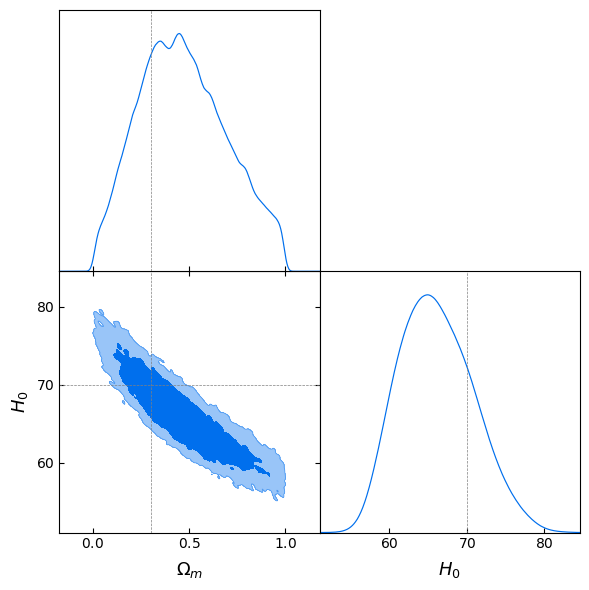

In [ ]:
# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

### Coverage test

In [ ]:
# Define HPD interval function
def HPD(samples, credible_mass=0.95):
    """
    Compute the highest posterior density (HPD) interval of the given samples for a given credible mass.
    
    Args:
        samples (np.ndarray): Array of samples.
        credible_mass (float): The desired credible mass for the HPD interval.
        
    Returns:
        (float, float): The lower and upper bounds of the HPD interval.
    """
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * len(sorted_samples)))
    n_intervals = len(sorted_samples) - interval_idx_inc
    interval_width = sorted_samples[interval_idx_inc:] - sorted_samples[:n_intervals]
    min_idx = np.argmin(interval_width)
    hdi_min = sorted_samples[min_idx]
    hdi_max = sorted_samples[min_idx + interval_idx_inc]
    return hdi_min, hdi_max

In [ ]:
# Function to sample posterior using MCMC
def sample_posterior_mcmc(log_posterior, x, n_samples=1000, nwalkers=20, nsteps=1000):
    ndim = 2
    initial_pos = np.random.randn(nwalkers, ndim) * 1e-3 + np.array([0.3, 70.0])

    # MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x,))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)

    # Get the samples
    samples = sampler.get_chain(discard=300, thin=15, flat=True)
    return samples

In [ ]:
# Generate test samples
n_test = 100
theta_test_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_test, 2))
x_test_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(theta_test_samples)])

# Normalize test data
x_test_samples_norm = (torch.tensor(x_test_samples, dtype=torch.float32) - x_mean) / x_std

100%|██████████| 100/100 [00:00<00:00, 655.33it/s]


In [ ]:
# Compute empirical coverage
p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

for i_param in range(2):
    for i, theta_test in enumerate(tqdm(theta_test_samples)):
        x_test = x_test_samples[i]
        posterior_samples = sample_posterior_mcmc(log_post, x_test, n_samples=1000)
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = HPD(posterior_samples[:, i_param], credible_mass=p_nominal)
            if hdi_min < theta_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

In [ ]:
# Calculate the empirical coverage
empirical_coverage = contains_true.mean(axis=1)

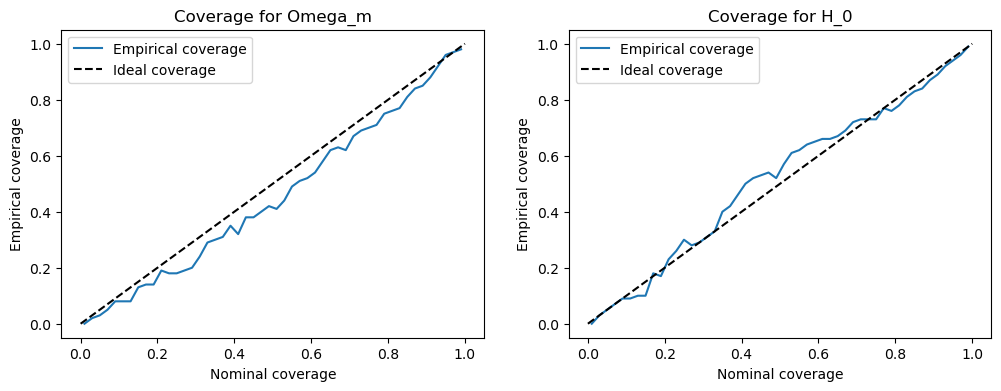

In [ ]:
# Plot the coverage
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

param_names = ["Omega_m", "H_0"]
for i in range(2):
    ax[i].plot(p_nominals, empirical_coverage[i], label='Empirical coverage')
    ax[i].plot([0, 1], [0, 1], color="black", linestyle="--", label='Ideal coverage')
    ax[i].set_xlabel("Nominal coverage")
    ax[i].set_ylabel("Empirical coverage")
    ax[i].set_title(f"Coverage for {param_names[i]}")
    ax[i].legend()

plt.show()

# Neural Likelihood Estimation (NLE)

This method is another Deep Learning implementation of *density estimation*, but this time we are interested in estimating the likelihood function $p(x | \theta)$. The procedure is similar to NPE, but we swap the target and conditional variables.
#### Training the conditional density estimator:
For the training part, in this case we have, similarly to NPE:
\begin{align*}
\min_\phi \mathbb{E}_{p(\theta)} \Big[ D_{KL}\big(p(x | \theta) || q_\phi(x | \theta)\big) \Big] &= \min_\phi \mathbb{E}_{p(\theta)}\mathbb{E}_{p(x | \theta)}\left[\log \frac{p(x | \theta)}{q_\phi(x | \theta)}\right] \\\\
&= \min_\phi \mathbb{E}_{p(\theta,x)} \left[ - \log q_\phi(x | \theta)\right] + \cancel{\mathrm{const}_{w.r.t. \phi}}
\end{align*}


#### The steps of the NLE algorithm are:
1. **Generate training data**: Sample a large number of parameter values $\theta$ from the prior, run the simulator to generate corresponding data $x$, and store the $(\theta, x)$ pairs as training data.
2. **Training the conditional density estimator**: 
    - evaluate the log-density of the NF, $\log q_\phi(x | \theta)$, at the training data points $(\theta, x)$.
    - wiggle the parameters $\phi$ of the NF until the log-likelihood of the training data is maximized.
    - the exact loss function is: $$\mathcal{L}(\phi, \varphi) = -\frac{1}{N} \sum_{i=1}^N \log q_\phi(x_i | \theta_i),$$ where $N$ is the number of training samples, and $\{ \phi, \varphi \}$ are the parameters of the NF and the feature extractor, respectively.
3. **Inference**: To perform inference for new parameters $\theta_{\text{obs}}$, we first need to sample from the NF model $q_\phi(x | \theta_{\text{obs}})$ to obtain samples from the likelihood function $p(x | \theta_{\text{obs}})$, and then run the standard Bayesian inference with MCMC to obtain the posterior distribution $p(\theta | x_{\text{obs}})$.

In [ ]:
# Define the neural likelihood estimator
class NeuralLikelihoodEstimator(pl.LightningModule):
    """Simple neural likelihood estimator class using a normalizing flow as the likelihood density estimator."""
    def __init__(self, d_context=2):
        super().__init__()
        self.flow = self._build_flow(d_in=50, d_hidden=128, d_context=d_context, n_layers=4)

    def _build_flow(self, d_in, d_hidden, d_context, n_layers):
        """ Instantiate a normalizing flow with Masked Autoregressive Transformations. """
        base_dist = StandardNormal(shape=[d_in])
        transforms = []
        for _ in range(n_layers):
            # Reverse permutation to shuffle the features
            transforms.append(ReversePermutation(features=d_in))
            # Masked Autoregressive Transform 
            transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
        
        # Combine all transformations into a composite transform
        transform = CompositeTransform(transforms)
        flow = Flow(transform, base_dist)
        return flow
    
    def loss(self, params, x):
        return -self.flow.log_prob(inputs=x, context=params) # Compute negative log probability

    def training_step(self, batch):
        params, x = batch
        loss = self.loss(params, x).mean() # Compute mean loss
        self.log("train_loss", loss) # Log the training loss
        return loss

    def validation_step(self, batch):
        params, x = batch
        loss = self.loss(params, x).mean() # Compute mean validation loss
        self.log("val_loss", loss) 
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

Instantiate the NeuralLikelihoodEstimator

In [ ]:
nle = NeuralLikelihoodEstimator()

Create the dataset and dataloader:

In [ ]:
# Create data loaders
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_norm))

dataset = TensorDataset(param_norm, x_norm)
dataset_train, dataset_val = random_split(dataset, [len(x_norm) - n_samples_val, n_samples_val])

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

Train the model:

In [ ]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nle, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/tersenov/anaconda3/envs/astrostat24/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tersenov/anaconda3/envs/astrostat24/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params | Mode 
--------------------------------------
0 | flow | Flow | 346 K  | train
--------------------------------------
346 K     Trainable params
0         Non-trainable pa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Now that we have trained the Normalizing Flow model to estimate the likelihood function $p(x | \theta)$, we can use it to do Bayesian inference. However, in this case, we will need to use MCMC to sample from the posterior distribution $p(\theta | x_{\text{obs}})$:

In [ ]:
# Define the prior distribution
def log_prior(params):
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0.0  # Uniform prior
    else:
        return -np.inf  # Log(0) for invalid values

# Define the log-posterior function
def log_posterior(params, x):    
    params = torch.tensor(params, dtype=torch.float32)
    x = torch.tensor(x, dtype=torch.float32)
    
    lp = log_prior(params)
    
    # Normalize
    x = (x - x_mean) / x_std
    context = (params - param_mean) / param_std
    context = context.unsqueeze(0)
    
    # Compute Likelihood
    with torch.no_grad():
        log_likelihood = nle.flow.log_prob(x.unsqueeze(0), context).item()

    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood

Now, let's generate a mock observed data $x_{\text{obs}}$ and use the trained NLE model to perform Bayesian inference and obtain samples from the posterior distribution $p(\theta | x_{\text{obs}})$.

In [ ]:
params_test = np.array([0.3, 70.0])
x_test = luminosity_distance_simulator(params_test, z)

In [ ]:
# Set up the MCMC sampler
ndim = 2
nwalkers = 20
nsteps = 3000

# Initial positions of the walkers
initial_pos = [params_test + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# Observed data
x_test = luminosity_distance_simulator(params_test, z)

# MCMC sampler
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_test,), pool=pool)
    sampler.run_mcmc(initial_pos, nsteps, progress=True)

100%|██████████| 3000/3000 [00:31<00:00, 94.97it/s] 


Removed no burn in


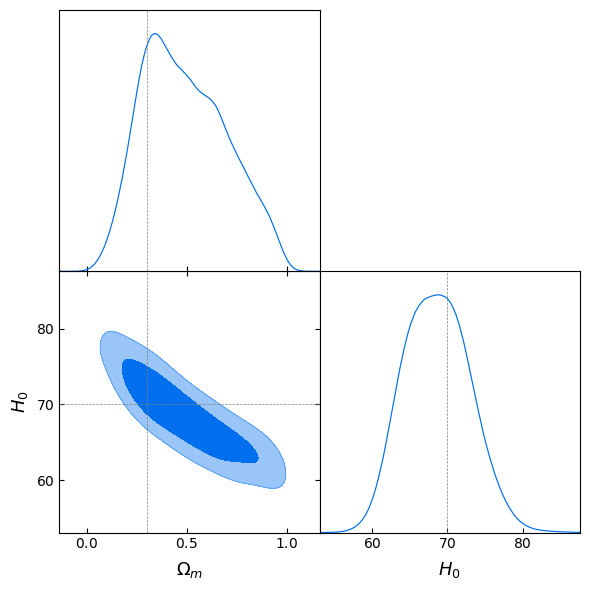

In [ ]:
# Get the samples
samples = sampler.get_chain(discard=500, thin=15, flat=True)

# Create a MCSamples instance
samples_mcs = MCSamples(samples=samples, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])

# Create a GetDist plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples_mcs], filled=True, markers={'\Omega_m': 0.3, 'H_0': 70})

plt.show()

Again, we see that the posteriors that we get from NLE are very similar to the "true" posterior that we got from standard Bayesian inference!

- **Advantage**: no need to retrain the model if we want to change the prior.
- **Drawback**: we need to use MCMC to sample from the posterior, which can be computationally expensive.

## Coverage test

In [ ]:
# Generate test samples
n_test = 200
param_test_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_test, 2))
x_test_samples = np.array([luminosity_distance_simulator(params_test, z) for params_test in tqdm(param_test_samples)])

# Normalize test data
x_test_samples_norm = (torch.tensor(x_test_samples, dtype=torch.float32) - x_mean) / x_std

100%|██████████| 200/200 [00:00<00:00, 821.26it/s]


In [ ]:
# Function to sample posterior using MCMC
def sample_posterior_mcmc(log_posterior, x, n_samples=1000, nwalkers=10, nsteps=1000):
    ndim = 2
    params_test = np.array([0.3, 70.0])
    initial_pos = [params_test + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

    # MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x,))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)

    # Get the samples
    samples = sampler.get_chain(discard=500, thin=15, flat=True)
    return samples

In [ ]:
# Compute empirical coverage
p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

In [ ]:
for i_param in range(2):
    for i, param_test in enumerate(tqdm(param_test_samples)):
        x_test = x_test_samples[i]
        posterior_samples = sample_posterior_mcmc(log_posterior, x_test, n_samples=1000)
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = HPD(posterior_samples[:, i_param], credible_mass=p_nominal)
            if hdi_min < params_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

In [ ]:
# Calculate the empirical coverage
empirical_coverage = contains_true.mean(axis=1)

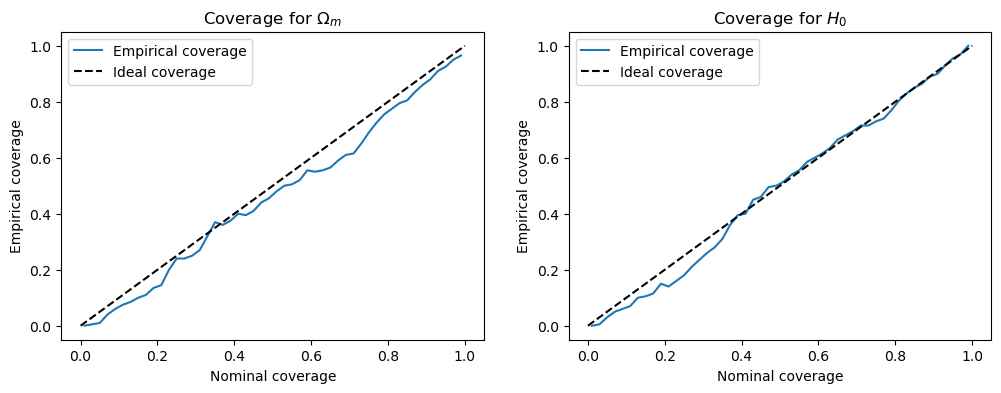

In [ ]:
# Plot the coverage
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

param_names = [r"$\Omega_m$", "$H_0$"]
for i in range(2):
    ax[i].plot(p_nominals, empirical_coverage[i], label='Empirical coverage')
    ax[i].plot([0, 1], [0, 1], color="black", linestyle="--", label='Ideal coverage')
    ax[i].set_xlabel("Nominal coverage")
    ax[i].set_ylabel("Empirical coverage")
    ax[i].set_title(f"Coverage for {param_names[i]}")
    ax[i].legend()

plt.show()

## Change the priors

As we mentioned before, one of the advantages of NLE is that we don't need to retrain the model if we want to change the prior. So let's assume that we have reason to believe that the prior distribution of the parameters $\theta$ is not uniform, but instead is a Gaussian distribution. We can easily change the prior distribution in the inference step by using the likelihood function $p(x | \theta)$ that we have estimated with NLE.

In [ ]:
mu_prior = np.array([0.3, 70.0])
sigma_prior = np.array([0.1, 10.0])

def log_prior_gauss(params):
    Omega_m, H0 = params
    prior_log_prob = -0.5 * (((params - mu_prior) / sigma_prior) ** 2).sum()
    return prior_log_prob

def log_posterior_gauss(params, x_obs, nle):
    params = torch.tensor(params, dtype=torch.float32)
    context = (params - param_mean) / param_std
    context = context.unsqueeze(0)
    
    with torch.no_grad():
        log_likelihood = nle.flow.log_prob(x_obs.unsqueeze(0), context).item()
    
    lp = log_prior_gauss(params.numpy())
    
    return log_likelihood + lp

In [ ]:
# Set up the MCMC sampler
ndim = 2
nwalkers = 20
nsteps = 3000

# Initial positions of the walkers
initial_pos = [params_test + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

# Observed data
x_obs = (torch.tensor(luminosity_distance_simulator(params_test, z), dtype=torch.float32) - x_mean) / x_std

# MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_gauss, args=(x_obs, nle))

# Run MCMC
sampler.run_mcmc(initial_pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=500, thin=15, flat=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:59<00:00, 50.54it/s]


Removed no burn in


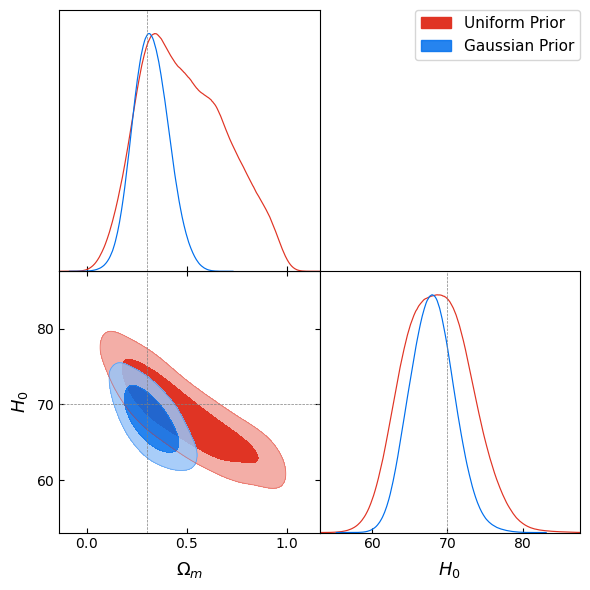

In [ ]:
# Create a MCSamples instance
samples_mcs_gauss = MCSamples(samples=samples, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])

# Create a GetDist plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples_mcs, samples_mcs_gauss], filled=True, markers={'\Omega_m': 0.3, 'H_0': 70}, legend_labels=['Uniform Prior', 'Gaussian Prior'])
plt.show()

# Sources & Further Reading


**This notebook is based on the following sources:**
- https://github.com/smsharma/sbi-lecture-mit
- https://astroautomata.com/blog/simulation-based-inference/
- https://github.com/maho3/ltu-ili/tree/main
- https://indico.mitp.uni-mainz.de/event/332/contributions/4532/
- https://indico.cern.ch/event/768915/contributions/3474655/
- https://github.com/glouppe/ssi2023
- https://lilianweng.github.io/posts/2018-10-13-flow-models/
- https://gebob19.github.io/normalizing-flows/
- https://arxiv.org/abs/1911.01429
- https://arxiv.org/abs/2402.05137
- https://arxiv.org/abs/2101.
- https://arxiv.org/abs/2403.14750

**Suggestions for further reading:**

- Blogs and general papers:
    - [Awesome Neural SBI (great list of resources on SBI that is frequently updated)](https://github.com/smsharma/awesome-neural-sbi)
    - [This blog post on Normalizing Flows](https://gebob19.github.io/normalizing-flows/)
    - [This other blog post on Normalizing Flows](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html)
    - [This review paper on SBI](https://arxiv.org/abs/1911.01429)
    - [This paper on benchmarking SBI methods](https://arxiv.org/abs/2101.04653)

- Some indicative papers on SBI applications in cosmology and astrophysics:
    - [Fast likelihood-free cosmology with neural density estimators and active learning](https://arxiv.org/abs/1903.00007)
    - [Fast likelihood-free inference in the LSS Stage IV era](https://arxiv.org/abs/2403.14750)
    - [SimBIG: Cosmological Constraints using Simulation-Based Inference of Galaxy Clustering with Marked Power Spectra](https://arxiv.org/abs/2404.04228)
    - [Real-time gravitational-wave science with neural posterior estimation](https://arxiv.org/abs/2106.12594)
    - [Constraining the X-ray heating and reionization using 21-cm power spectra with Marginal Neural Ratio Estimation](https://arxiv.org/abs/2303.07339)
    - [Neural posterior estimation for exoplanetary atmospheric retrieval](https://arxiv.org/abs/2301.06575)

- Some nice SBI libraries:
    - [`sbi`](https://github.com/mackelab/sbi)
    - [`pydelfi`](https://github.com/justinalsing/pydelfi)
    - [`ltu-ili`](https://github.com/maho3/ltu-ili)

    